In [1]:
import logging
import time
import jax
import optax
import data
import dataclasses

import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
import haiku as hk
import typing as t
import jax.numpy as jnp
import numpy as np

from jax import lax
from my_attention import MyMultiHeadAttention

plt.rcParams['figure.figsize'] = [10, 5]

### statics

In [2]:
# 36 is 3 hours, rounding up to the nearest power of 2 -> 64
BLOCK_SIZE = 32 # de facto it'll be x4 after byte encoding
BATCH_SIZE = 4
SPLIT = 0.85
LEARNING_RATE = 3e-4
SEED = 2137
NUM_TRAINING_STEPS = 250000
EVAL_INTERVAL = 1000
EMBEDDING_SIZE = 4

VOCAB_SIZE = 256
PAD_TOKEN = jnp.array(-1, dtype=jnp.int16)
GRAD_CLIP_VALUE = 1

NUM_LAYERS = 1
NUM_HEADS = 8  # Number of attention heads.

# based on https://proceedings.neurips.cc/paper/2020/file/ff4dfdf5904e920ce52b48c1cef97829-Paper.pdf
# MODEL_SIZE = exp(5.039) exp(0.0555 · NUM_LAYERS)
MODEL_SIZE = 64
KEY_SIZE = 8  # a.k.a HEAD_SIZE ~ NUM_HEADS * HEAD_SIZE = MODEL_SIZE
DROPOUT_RATE = 0.1
SOFTMAX_TEMP = 1.5
EMBEDDING_DTYPE = jnp.int16

LOAD_WEIGHTS = False

### utils

In [3]:
class TrainingState(t.NamedTuple):
  """Container for the training state."""
  params: hk.Params
  opt_state: optax.OptState
  rng: jax.Array
  step: jax.Array
    
class LoopValues(t.NamedTuple):
    logits: jnp.ndarray
    output_seq: jnp.ndarray

class Batch(t.NamedTuple):
    inputs: np.ndarray  # Integer tokens, shape [B, T]
    targets: np.ndarray  # Integer tokens, shape [B, T]

Metrics = t.MutableMapping[str, t.Any]

In [4]:
@jax.jit
def local_label_smoothing(arr: jnp.array, std: int = 2, mean: float = 0.7):
    # EXAMPLE: circular convolution
    # 
    # input: [0, 0, 1], in our case it will be always queal to VOCAB_SIZE
    # core: [.1, .8. .1]
    # 
    # [1, 0, 0 | 0, 0, 1 | 1, 0, 0]
    #   convolution into 
    # [.8, 0.1, 0 | 0, .1, .9 | .9, .1, 0]
    # return the middle
    conv_core = jnp.array([.05, .1, .7, .1, .05])
    vs = arr.shape[-1]
    arr = jnp.concatenate((jnp.flip(arr, axis=1), arr, jnp.flip(arr, axis=1)), axis=-1)
    convd = jnp.apply_along_axis(lambda x: jnp.convolve(conv_core, x, mode="same"), -1, arr)    
    return convd[..., VOCAB_SIZE:VOCAB_SIZE*2]

In [5]:
@jax.jit
def to_bytes(arr):
  """ Converts an array of uint32 into an array of bytes in little endian"""

  @ft.partial(jax.vmap, in_axes=(None, 0), out_axes=-1)
  def _to_bytes(arr, byte_index:int):
    mask = 0xFF << (8 * byte_index)
    b = (arr & mask) >> 8 * byte_index
    return  b.astype(EMBEDDING_DTYPE)

  return _to_bytes(arr, jnp.arange(4))

@ft.partial(jax.jit, static_argnames=("axis"))
def from_bytes(array, axis):
  """ Converts an array of bytes in little endian  into an array of uint32"""

  @ft.partial(jax.vmap, in_axes=(axis, -1))
  def _from_bytes(arr, byte_index):
    return arr << 8 * byte_index

  return jnp.sum(_from_bytes(array, jnp.arange(4)), axis=axis)

@jax.jit
def decode_bytes(arr: jnp.array) -> jnp.array:
    assert arr.shape[1] % EMBEDDING_SIZE == 0
    mask = jnp.array([1, 256, 256*256, 256*256*256])
    
    w = arr.shape[1] // EMBEDDING_SIZE
    res = arr.reshape((BATCH_SIZE, w, EMBEDDING_SIZE))
    res = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, res)
    return res

### load data

In [6]:
sdl = data.SimpleDataLoader("../data/samples_5m_subset_v1.csv",
                            BLOCK_SIZE,
                            BATCH_SIZE,
                            EMBEDDING_SIZE,
                            SPLIT,
                            normalize=False,
                            log=False,
                            shift=False,
                            batch_first=True
                            )
train_di = sdl.get_data_iter("train")
test_di = sdl.get_data_iter("test")

In [7]:
expl_batch = next(train_di)
expl_batch["target"].shape

(4, 32)

In [8]:
expl_batch['input'][0, :4]

Array([1989, 2237, 5694, 3467], dtype=int32)

In [9]:
to_bytes(expl_batch['input'])[0, :3, :]

Array([[197,   7,   0,   0],
       [189,   8,   0,   0],
       [ 62,  22,   0,   0]], dtype=int16)

In [10]:
@jax.jit
def preproc_data(batch: dict):
    _inputs = to_bytes(batch['input'])
    _targets = to_bytes(batch['target'])
    # TODO: make it a bit cleaner
    _inputs = _inputs.reshape((BATCH_SIZE, EMBEDDING_SIZE*BLOCK_SIZE))
    _targets = _targets.reshape((BATCH_SIZE, EMBEDDING_SIZE*BLOCK_SIZE))
    return Batch(inputs=_inputs, targets=_targets)

In [11]:
@jax.jit
def apply_byte_error_weights(arr: jnp.array):
    assert arr.shape[1] % EMBEDDING_SIZE == 0
    c = arr.shape[1] // EMBEDDING_SIZE
    
    # the first byte is virtually impossible to model as it's pure noise,
    # therefore we rescale the related error to have low impact on the loss
    weights = jnp.array([0.1, 0.5, 3., 4.] * c)
    return weights*arr

In [12]:
apply_byte_error_weights(jnp.ones((4, 16)))

Array([[0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1,
        0.5, 3. , 4. ],
       [0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1,
        0.5, 3. , 4. ],
       [0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1,
        0.5, 3. , 4. ],
       [0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1, 0.5, 3. , 4. , 0.1,
        0.5, 3. , 4. ]], dtype=float32)

In [13]:
_inputs = preproc_data(expl_batch)
_inputs.inputs.shape, _inputs.inputs.dtype

((4, 128), dtype('int16'))

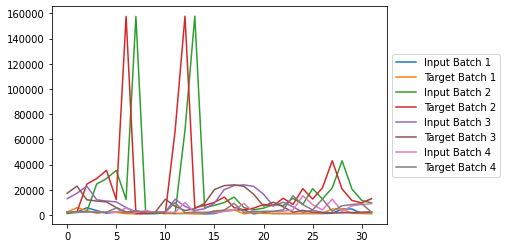

In [14]:
plt.figure()

plt.plot(expl_batch['input'][0], label="Input Batch 1")
plt.plot(expl_batch['target'][0], label="Target Batch 1")

plt.plot(expl_batch['input'][1], label="Input Batch 2")
plt.plot(expl_batch['target'][1], label="Target Batch 2")

plt.plot(expl_batch['input'][2], label="Input Batch 3")
plt.plot(expl_batch['target'][2], label="Target Batch 3")

plt.plot(expl_batch['input'][3], label="Input Batch 4")
plt.plot(expl_batch['target'][3], label="Target Batch 4")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

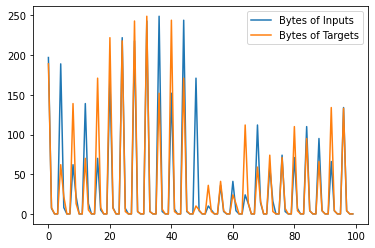

In [15]:
plt.figure()
plt.plot(_inputs.inputs[0, :100], label="Bytes of Inputs")
plt.plot(_inputs.targets[0, :100], label="Bytes of Targets")
plt.legend()
plt.show()

### model

from: https://github.com/deepmind/dm-haiku/tree/main/examples/transformer

In [16]:
"""Didactic example of an autoregressive Transformer-based language model.
Glossary of shapes:
- B: Batch size.
- T: Sequence length.
- D: Model embedding size.
- H: Number of attention heads.
- V: Vocabulary size.
"""

def layer_norm(x: jax.Array) -> jax.Array:
    """Applies a unique LayerNorm to x with default settings."""
    ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
    return ln(x)

def get_alibi_mask() -> jax.Array:
    """
    ATTENTION WITH LINEAR BIASES - ALiBi positional embeddings 
    
    based on https://arxiv.org/pdf/2108.12409.pdf
    """
    seq_len = int(BLOCK_SIZE * EMBEDDING_SIZE)
    
    # there is a slope for each of the heads
    pwr = jnp.arange(NUM_HEADS) + 1
    slopes = jnp.power(2, -8/pwr)
    
    matrix = jnp.zeros((seq_len, seq_len), dtype=jnp.int32)
    
    # TODO: it's gross, rewrite
    for idx in range(seq_len):
        col1 = -jnp.arange(seq_len)
        col1 = jnp.pad(col1, (idx, 0))[:seq_len]
        matrix = lax.dynamic_update_slice(matrix, col1[:, None], (0, idx))
        
    sloped_matrix = jax.vmap(lambda s: s*matrix, out_axes = 0)(slopes)
    return sloped_matrix[None, ...] # [B=1, H, T, T]

alibi_mask = get_alibi_mask()
    
@dataclasses.dataclass
class Transformer(hk.Module):
  """A transformer stack."""

  num_heads: int
  num_layers: int
  key_size: int
  dropout_rate: float
  widening_factor: int = 4
  name: t.Optional[str] = None

  def __call__(
      self,
      embeddings: jax.Array,  # [B, T, D]
      mask: jax.Array,  # [B, T]
      *,
      is_training: bool = True,
  ) -> jax.Array:  # [B, T, D]
    """Transforms input embedding sequences to output embedding sequences."""

    initializer = hk.initializers.VarianceScaling(2 / self.num_layers)
    dropout_rate = self.dropout_rate if is_training else 0.
    _, seq_len, model_size = embeddings.shape

    # Compute causal mask for autoregressive sequence modelling.
    mask = mask[:, None, None, :]  # [B, H=1, T'=1, T]
    causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len)))  # [B=1, H=1, T, T]
    mask = mask * causal_mask  # [B, H=1, T, T]

    h = embeddings
    for _ in range(self.num_layers):
      # First the attention block.
      attn_block = MyMultiHeadAttention(
          num_heads=self.num_heads,
          key_size=self.key_size,
          model_size=model_size,
          w_init=initializer,
      )
      h_norm = layer_norm(h)
      h_attn = attn_block(h_norm, h_norm, h_norm, mask = mask, alibi_mask = alibi_mask)
      h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
      h = h + h_attn

      # Then the dense block.
      dense_block = hk.Sequential([
          hk.Linear(self.widening_factor * model_size, w_init=initializer),
          jax.nn.gelu,
          hk.Linear(model_size, w_init=initializer),
      ])
      h_norm = layer_norm(h)
      h_dense = dense_block(h_norm)
      h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
      h = h + h_dense

    return layer_norm(h)


@dataclasses.dataclass
class TransformerModel(hk.Module):
  """An autoregressive transformer-based model."""

  transformer: Transformer
  model_size: int
  vocab_size: int
  pad_token: int
  name: t.Optional[str] = None

  def __call__(
      self,
      tokens: jax.Array,
      *,
      is_training: bool = True,
  ) -> jax.Array:
    """Forward pass, producing a sequence of logits."""
    
    input_mask = jnp.greater(tokens, self.pad_token)
    unused_batch_size, seq_len = tokens.shape

    # Embed the input tokens and positions.
    # initializers parametrizes as suggested in https://arxiv.org/abs/2201.11990
    # std = sqrt(1/(D*3))
    embed_init = hk.initializers.RandomNormal(stddev=0.072)
    token_embedding_map = hk.Embed(
        self.vocab_size, embed_dim=self.model_size, w_init=embed_init)
    token_embeddings = token_embedding_map(tokens)
    
    _byte_position_embeddings = hk.get_parameter(
        'byte_position_embeddings', [EMBEDDING_SIZE, self.model_size], init=embed_init)
    
    # BYTE POSIOTION EMBEDDINGS
    byte_position_embeddings = _byte_position_embeddings
    for _ in range((seq_len // EMBEDDING_SIZE) - 1) :
        byte_position_embeddings = jnp.concatenate(
            (byte_position_embeddings, _byte_position_embeddings), axis=0)
    byte_position_embeddings = byte_position_embeddings[None, :, :]
    
    # INT POSIOTION EMBEDDINGS
    int_positional_embeddings = hk.get_parameter(
        'int_positional_embeddings', [BLOCK_SIZE, self.model_size], init=embed_init)
    # all byte tokens from a single int get the same inp_positional_emb
    int_positional_embeddings = jnp.repeat(int_positional_embeddings, EMBEDDING_SIZE, axis=0)
    
    # in the ALiBi paper they use no positional embeddings and fully rely on ALiBi
    input_embeddings = token_embeddings + byte_position_embeddings # + int_positional_embeddings # [B, T, D]
    
    # we want to predict following 4 bytes
    for i in range(4):
        # Run the transformer over the inputs.
        embeddings = self.transformer(
            input_embeddings[:, i:],
            input_mask,
            is_training=is_training,
        )  # [B, T, D]
        next_logit = jnp.argmax(embeddings[:, -1:], axis=-1) # [B, 1]
        next_logit = token_embedding_map(next_logit) # [B, 1, D]
        input_embeddings = jnp.concatenate((input_embeddings, next_logit), axis=1)
    
    # Decode the embeddings (here, we use untied weights).
    return hk.Linear(self.vocab_size)(embeddings)  # [B, T, V]

### training

In [17]:
def forward(tokens: t.Union[np.ndarray, jax.Array]) -> jax.Array:
    net = TransformerModel(
        model_size=MODEL_SIZE,
        vocab_size=VOCAB_SIZE,
        pad_token=PAD_TOKEN,
        transformer=Transformer(
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            key_size=KEY_SIZE,
            dropout_rate=DROPOUT_RATE,
        ),
    )
    return net(tokens)

# Create the optimiser.
optimiser = optax.chain(
  optax.clip_by_global_norm(GRAD_CLIP_VALUE),
  optax.adamw(LEARNING_RATE, b1=0.9, b2=0.95, weight_decay=0.1),
)

# Create the loss.
@hk.transform
def loss_fn(batch: Batch) -> t.Tuple[jax.Array, Metrics]:
    """Computes the (scalar) loss on `data` w.r.t. params."""
    inp = batch.inputs
    out = batch.targets
    
    logits = forward(inp)
    
    # this mask excludes -1's which we use as a padding in an input seq
    input_mask = jnp.greater(inp, jnp.array(-1, dtype=jnp.int16))
    targets = jax.nn.one_hot(out, VOCAB_SIZE)  # (B, T*D, 256)
    ### LOCAL LABEL SMOOTHING ###
    targets = local_label_smoothing(targets)
    
    assert logits.shape == targets.shape
    
    log_sft = jax.nn.log_softmax(logits / SOFTMAX_TEMP)
    log_likelihood = jnp.sum(targets * log_sft, axis=-1) # (B, T)
    
    predictions = jnp.argmax(log_sft, axis=-1) # (B, T)
    #  neighbouring classes are similar therefore we use calculate accuracy 
    #  for the closes 1 and 2 heighbours as well
    out = out.astype(jnp.int32) # convert to signed int in order to make correct comparisons
    acc = jnp.asarray(predictions == out).reshape((BATCH_SIZE, BLOCK_SIZE, 4))
    acc3 = jnp.logical_and(predictions <= out + 1, predictions >= out - 1)
    acc3 = acc3.reshape((BATCH_SIZE, BLOCK_SIZE, 4))
    acc5 = jnp.logical_and(predictions <= out + 2, predictions >= out - 2)
    acc5 = acc5.reshape((BATCH_SIZE, BLOCK_SIZE, 4))
    
    # mae = jnp.mean(jnp.abs(decode_bytes(predictions) - decode_bytes(out)))
    
    # (out [B, T], predictions [B, T]) -> [E, E]
    confusion_matrix = jnp.matmul(jnp.transpose(jax.nn.one_hot(out, VOCAB_SIZE), (0, 2, 1)), 
                                  jax.nn.one_hot(predictions, VOCAB_SIZE))
    
    metrics = {
        'accuracy': acc.mean(axis=(0, 1)),
        'accuracy_3': acc3.mean(axis=(0, 1)),
        'accuracy_5': acc5.mean(axis=(0, 1)),
        'conf_mat': confusion_matrix,
        # 'mae' : mae
    }
        
    log_likelihood = jnp.sum(targets * jax.nn.log_softmax(logits / SOFTMAX_TEMP), axis=-1)
    ### BYTE-LEVEL ERROR SCALING ###
    # the last token is the first byte of the prediction
    # it's scaled by 1.0, so we can skip it and it would have the same effect
    log_likelihood = apply_byte_error_weights(log_likelihood)
    return -jnp.sum(log_likelihood * input_mask) / jnp.sum(input_mask), metrics  # NLL per token.

@jax.jit
def update(state: TrainingState, batch) -> t.Tuple[TrainingState, Metrics]:
    """Does an SGD step and returns metrics."""
    rng, new_rng = jax.random.split(state.rng)
    loss_and_grad_fn = jax.value_and_grad(loss_fn.apply, has_aux=True)
    (loss, metrics), gradients = loss_and_grad_fn(state.params, rng, batch)

    updates, new_opt_state = optimiser.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng=new_rng,
        step=state.step + 1,
    )

    metrics.update({
        'step': state.step,
        'loss': loss,
    })
    return new_state, metrics

model initialization

In [18]:
rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)
init_batch = preproc_data(expl_batch)
initial_params = loss_fn.init(init_rng, init_batch)

initial_opt_state = optimiser.init(initial_params)
initial_state =  TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng=init_rng,
    step=jnp.array(0),
)

metrics

In [19]:
num_params = 0
for l in initial_state.params:
    for p in initial_state.params[l]:
        num_params += initial_state.params[l][p].size

num_params

85440

In [20]:
metrics_avg: Metrics = {}

def record_metrics(metrics: t.Mapping):
    for k, v in metrics.items():
        v = jnp.expand_dims(v, -1)
        if k in metrics_avg:
            metrics_avg[k] = jnp.concatenate((metrics_avg[k], v), axis=-1)
        else:
            metrics_avg[k] = v

training loop

In [21]:
if LOAD_WEIGHTS:
    model_params = jnp.load('transformer_a_la_karpathy_uniform_batch.npy', allow_pickle=True)
else:
    avg_loss = []
    confusion_matrix = jnp.zeros((BATCH_SIZE, VOCAB_SIZE, VOCAB_SIZE))
    prev_time = time.time()
    training_start_ts = time.time()
    state = initial_state
    for step in range(NUM_TRAINING_STEPS + 1):
        batch = preproc_data(next(train_di))
        state, metrics = update(state, batch)
        # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
        # Using values from state/metrics too often will block the runahead and can
        # cause these overheads to become more prominent.
        
        #
        if step % EVAL_INTERVAL == 0:
            steps_per_sec = EVAL_INTERVAL / (time.time() - prev_time)
            prev_time = time.time()
            rng, new_rng = jax.random.split(rng)
            valid_loss, _ = loss_fn.apply(state.params, new_rng, preproc_data(next(test_di))) 
            
            metrics.update({'steps_per_sec': steps_per_sec, 'valid_loss': valid_loss})
            
            confusion_matrix = confusion_matrix + metrics['conf_mat']
            
            record_metrics(metrics)
            
            print(f"{(time.time() - training_start_ts)/60:0.1f} min, " \
                  f"Step: {step}, " \
                  f"Loss: {metrics['loss']:.2f}, " \
                  f"Vloss: {metrics['valid_loss']:.2f}, " \
                  f"Acc: {[f'{i:0.2f}' for i in metrics['accuracy']]}, " \
                  f"Acc3: {[f'{i:0.2f}' for i in metrics['accuracy_3']]}, " \
                  # f"MAE: {metrics['mae']:.2f}, " \
                  f"")  
            
    final_params = state.params

0.1 min, Step: 0, Loss: 9.70, Vloss: 8.87, Acc: ['0.00', '0.00', '0.00', '0.00'], Acc3: ['0.01', '0.01', '0.00', '0.00'], 
0.3 min, Step: 1000, Loss: 3.99, Vloss: 3.46, Acc: ['0.00', '0.01', '0.07', '1.00'], Acc3: ['0.00', '0.01', '0.26', '1.00'], 
0.4 min, Step: 2000, Loss: 5.92, Vloss: 5.12, Acc: ['0.00', '0.00', '0.01', '0.70'], Acc3: ['0.00', '0.02', '0.06', '0.95'], 
0.6 min, Step: 3000, Loss: 6.00, Vloss: 4.26, Acc: ['0.00', '0.00', '0.02', '0.68'], Acc3: ['0.00', '0.00', '0.05', '0.95'], 
0.7 min, Step: 4000, Loss: 4.43, Vloss: 4.09, Acc: ['0.00', '0.00', '0.15', '0.90'], Acc3: ['0.00', '0.02', '0.26', '0.98'], 
0.8 min, Step: 5000, Loss: 2.86, Vloss: 5.58, Acc: ['0.01', '0.01', '0.45', '1.00'], Acc3: ['0.01', '0.02', '0.78', '1.00'], 
1.0 min, Step: 6000, Loss: 5.10, Vloss: 1.60, Acc: ['0.00', '0.01', '0.02', '0.95'], Acc3: ['0.02', '0.01', '0.08', '1.00'], 
1.1 min, Step: 7000, Loss: 1.78, Vloss: 3.28, Acc: ['0.00', '0.02', '0.96', '1.00'], Acc3: ['0.01', '0.07', '0.98', '1.00

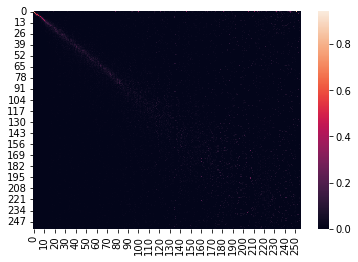

In [22]:
if not LOAD_WEIGHTS:
    sns.heatmap(confusion_matrix.sum(0)/(confusion_matrix.sum((0,1)) + 1))

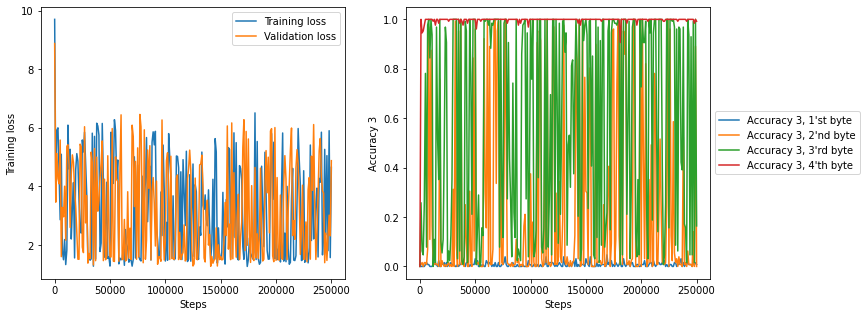

In [23]:
if not LOAD_WEIGHTS:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(metrics_avg['step'], metrics_avg['loss'], label = "Training loss")
    ax1.plot(metrics_avg['step'], metrics_avg['valid_loss'], label = "Validation loss")
    ax1.set(xlabel='Steps', ylabel='Training loss')
    ax1.legend()

    ax2.plot(metrics_avg['step'], metrics_avg['accuracy_3'][0], label = "Accuracy 3, 1'st byte")
    ax2.plot(metrics_avg['step'], metrics_avg['accuracy_3'][1], label = "Accuracy 3, 2'nd byte")
    ax2.plot(metrics_avg['step'], metrics_avg['accuracy_3'][2], label = "Accuracy 3, 3'rd byte")
    ax2.plot(metrics_avg['step'], metrics_avg['accuracy_3'][3], label = "Accuracy 3, 4'th byte")
    ax2.set(xlabel='Steps', ylabel='Accuracy 3')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.show()

### validation

In [24]:
if LOAD_WEIGHTS:
    model_weights = model_params.item()
else:
    model_weights = final_params

save model weights

In [25]:
if not LOAD_WEIGHTS:
    with open('transformer_a_la_karpathy_uniform_batch.npy', 'wb') as f:
        jnp.save(f, state.params)

In [27]:
@hk.transform
def generate(context: jnp.array, seq_len: int) -> jnp.array:
    output_seq = jnp.zeros((BATCH_SIZE, seq_len, 4))
    new_input = jnp.array(context, dtype = jnp.int32) # initial input

    def body_fn(idx: int, v: LoopValues) -> LoopValues:
        new_logits = forward(v.logits)  # (B, T*D, 256)
        new_logits = jax.random.categorical(hk.next_rng_key(), new_logits, axis=-1)  # (B, T*D)
        new_output_seq = v.output_seq.at[:, idx, :].set(new_logits[:, -4:])
        return LoopValues(logits = new_logits, output_seq=new_output_seq)
        
    initial_values = LoopValues(logits=new_input, output_seq=output_seq)
    lv: LoopValues = hk.fori_loop(0, seq_len, body_fn, initial_values) 
    mask = jnp.array([1, 256, 256*256, 256*256*256])
    return jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, lv.output_seq)

@hk.transform
def generate_full_seq(context: jnp.array) -> jnp.array:
    inp = context
    logits = forward(inp)  # (B, T*D, 256)
    
    logits = jax.random.categorical(hk.next_rng_key(), logits, axis=-1)
    res = decode_bytes(logits)
    return res, logits

In [28]:
rng = hk.PRNGSequence(SEED)

In [29]:
test_batch = preproc_data(next(test_di))

_predictions, lg = generate_full_seq.apply(model_weights, next(rng), test_batch.inputs)
_predictions.shape

(4, 32)

In [30]:
context = decode_bytes(test_batch.targets)
context.shape

(4, 32)

In [31]:
print(f"MAE ... {jnp.mean(jnp.abs(_predictions - context))}")

MAE ... 3015067.5


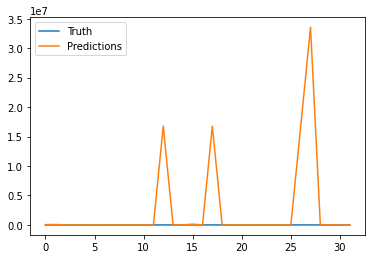

In [32]:
plt.figure()
# plt.plot(context[0] + 2**16, label="error margin", color="red")
# plt.plot(context[0] - 2**16, label="error margin", color="red")
plt.plot(context[0], label="Truth")
plt.plot(_predictions[0], label="Predictions")
plt.legend()
plt.show()

In [48]:
predictions = generate.apply(model_weights, next(rng), test_batch.inputs, 580) # 580 samples is about 2 days
predictions.shape

(4, 580)

In [49]:
target = decode_bytes(test_batch.targets)
target.shape

(4, 32)

we draw additional error margins corresponding to the maximum error from the first two bytes

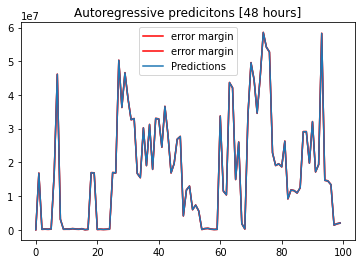

In [53]:
plt.figure()
plt.plot(predictions[0, :100] + 2**16, label="error margin", color="red")
plt.plot(predictions[0, :100] - 2**16, label="error margin", color="red")
plt.plot(predictions[0, :100], label="Predictions")
# plt.plot(target[0], label="Context")
plt.legend()
plt.title("Autoregressive predicitons [48 hours]")
plt.show()

entire test sequence predictions

In [36]:
test_data_full = sdl.edges_test_data  # (E, NUM_TEST_SAMPLES)
print(test_data_full.shape)

(18, 24341)


In [38]:
generate_mapped = jax.vmap(generate_full_seq.apply, (None, None, -1), -1)

In [39]:
# flatten test_data_full
test_data_full = jnp.ravel(to_bytes(test_data_full))

# split test_data_full into N batches -> (T, N) 
tail = test_data_full.shape[0] % (BLOCK_SIZE*EMBEDDING_SIZE*BATCH_SIZE)
test_data_full = test_data_full[:-tail]
N = test_data_full.shape[0] // BATCH_SIZE
test_data_full = test_data_full.reshape((BATCH_SIZE, N))
print(test_data_full.shape)
print(test_data_full[0, :16])

# split into inference batches -> (B, T, N) 
N = N // (BLOCK_SIZE*EMBEDDING_SIZE)
test_data_full = test_data_full.reshape((BATCH_SIZE, N, -1), order="C").transpose((0, 2, 1))
print(test_data_full.shape)
print(test_data_full[0, :16, 0])

(4, 438016)
[ 60  86   0   0  31  86   0   0 229  82   0   0  25  88   0   0]
(4, 128, 3422)
[ 60  86   0   0  31  86   0   0 229  82   0   0  25  88   0   0]


we do it in 3 batches in order to avoid GPU memory allocation problems

In [40]:
new_rng = next(rng)
full_seq_predictions = generate_mapped(model_weights, new_rng, test_data_full[..., :1000])
second_batch_preds = generate_mapped(model_weights, new_rng, test_data_full[..., 1000:2000])
full_seq_predictions = jnp.concatenate((full_seq_predictions[0], second_batch_preds[0]), axis=-1)
second_batch_preds = generate_mapped(model_weights, new_rng, test_data_full[..., 2000:])
full_seq_predictions = jnp.concatenate((full_seq_predictions, second_batch_preds[0]), axis=-1)
full_seq_predictions.shape

(4, 32, 3422)

In [41]:
v_decode_bytes = jax.vmap(decode_bytes, -1, -1)
test_data_full_decoded = v_decode_bytes(test_data_full)
test_data_full_decoded.shape

(4, 32, 3422)

In [42]:
jnp.mean((jnp.abs(test_data_full_decoded[:, 1:] - full_seq_predictions[:, :-1])))

Array(2376025.2, dtype=float32)

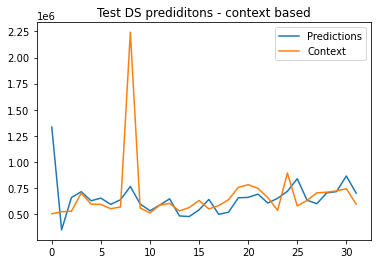

In [74]:
rnd_sample_idx = jax.random.randint(next(rng), (1, ), 0, test_data_full_decoded.shape[-1]).item()

plt.figure()
plt.plot(full_seq_predictions[0, :, rnd_sample_idx], label="Predictions")
plt.plot(test_data_full_decoded[0, :, rnd_sample_idx], label="Context")
plt.legend()
plt.title("Test DS prediditons - context based")
plt.show()

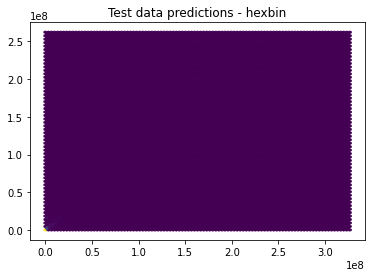

In [75]:
plt.figure()
plt.hexbin(x = jnp.ravel(test_data_full_decoded[:, 1:]), y = jnp.ravel(full_seq_predictions[:, :-1]))
plt.title("Test data predictions - hexbin")
plt.show()